In this notebook we created our train and validation sets on which we trained our models of catboost and xgboost. We got 2 kinds of files - based on newest rows and based on the distribution of the feature user_target_recs

#Mount drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

In [ ]:
home_path = "/content/drive/MyDrive/RS_Kaggle_Competition"

In [ ]:
test_path = home_path + "/" + "test" + "/test_file.csv"

In [ ]:
test_df = pd.read_csv(test_path)

In [ ]:
test_df.head()

,page_view_start_time,user_id_hash,target_id_hash,syndicator_id_hash,campaign_id_hash,empiric_calibrated_recs,empiric_clicks,target_item_taxonomy,placement_id_hash,user_recs,user_clicks,user_target_recs,publisher_id_hash,source_id_hash,source_item_type,browser_platform,os_family,country_code,region,day_of_week,time_of_day,gmt_offset,Id
0,1587359560809,26bd0dea68c5f65c286ead5f6a69218486cc965535ae39...,79f2e0095aca1d3afac3a4918f2fc77aa3dd386537447a...,377402b6b9107d4c2d3d7cd40218ab1578ffd15554a2c7...,26443482ee16a2b3653fab3cbf84eb2c3931520a985db5...,1360.87550,7444.0,SPORTS~FIGHTING,911f042701f83ed9e2c3ee0951dd2f9e1dc0302ca5a03a...,83.0,0.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,homepage,DESK,6,US,AZ,0,22,-700,1
1,1587341629681,f183602e0fe86592a106e62230d05ecc02212be60def80...,1077d1cd2590b9318ce5bf1b63f323706d9b3734234640...,fe55e950d29575f0dd1a02958cedaeb271ca167482c1bc...,1b40924dcbe3fe73d7ba308be724d722c6279ace116e78...,62687.11700,70074.0,LIFE~HEALTH-AND-FITNESS,736ce0a301eb0c3da05800df13949e411684c97236aa22...,59.0,0.0,0.0,c29a980222a2a97b74ffbd067f2a4ce760e3e8d8f02494...,4c7987d659b97d2007c45bb3c9fd903b135a2ef18130f7...,homepage,DESK,6,US,IN,0,20,-400,3
2,1587406996730,a35e998230d1c5a2dd0ee62004dd0dfe47b0fd29b1e20c...,9a4de107996cf896aed161e9579b1384464b363aae7e2c...,fe55e950d29575f0dd1a02958cedaeb271ca167482c1bc...,b94436fabe57b43407e63bbf23cdeccb237603b6104425...,42247.43800,68905.0,LIFE~HEALTH,3df5c61ea574ff3b3df24ce8d6479af393d1df05048150...,5.0,0.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,389b69708cf58731e78e2e023a8c608d886fe5aebc0e23...,category,DESK,6,US,OH,1,14,-400,5
3,1587426992796,c0901569facec5fbe96f16a15c7674d57da91916a82d72...,770a38ba68a2b9a6647d8db845fc68ff9bd3e0d09b7c8b...,26fb5310eed046f76c8ab6ea27e96b275771bd9f49c107...,e154a93347c6f190739b5d454cbbb7a623bd6f32242332...,263.02994,210.0,UNKNOWN,2a252fe72b34a7a10c784178e6def75b3e7226194daf95...,15.0,5.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,b0c391512c4c4829dd44b4c6429a4b4e474d0a61f55f8a...,text,PHON,3,US,NY,1,19,-400,6
4,1587408832707,18c2e5a4263f4464b096a056ad14d04aa901c9bc8ac0a7...,79f2e0095aca1d3afac3a4918f2fc77aa3dd386537447a...,377402b6b9107d4c2d3d7cd40218ab1578ffd15554a2c7...,26443482ee16a2b3653fab3cbf84eb2c3931520a985db5...,1500.63540,8073.0,SPORTS~FIGHTING,a5bc8458778dcec7656c4bfa2045322e0042ca7ea4b84d...,261.0,0.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,389b69708cf58731e78e2e023a8c608d886fe5aebc0e23...,category,DESK,6,US,VA,1,14,-400,9


In [ ]:
print(f"test shape: {test_df.shape}")


test shape: (444506, 23)


user_target_recs histogram:


0.0     368579
1.0      36468
2.0      14722
3.0       7272
4.0       4358
         ...  
80.0         1
99.0         1
82.0         1
91.0         1
81.0         1
Name: user_target_recs, Length: 95, dtype: int64

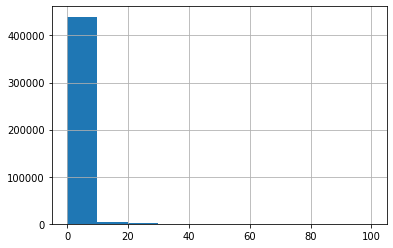

In [ ]:
# get the distribution of user_target_recs

print("user_target_recs histogram:")
test_df["user_target_recs"].hist()
test_df["user_target_recs"].value_counts()

user_recs_histogram


0.0       112851
3.0        10185
1.0        10088
2.0         8581
4.0         6510
           ...  
2190.0         1
2549.0         1
2720.0         1
2289.0         1
2588.0         1
Name: user_recs, Length: 2534, dtype: int64

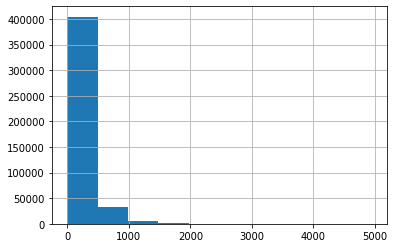

In [ ]:
# get the distribution of user_recs

print("user_recs_histogram")
test_df["user_recs"].hist()
test_df["user_recs"].value_counts()

#Data starting at the 17th of April

We take only new data - starting on 17.4.2020

In [ ]:

def get_train_files_paths(path):
  dir_paths = [ os.path.join(path, dir_name) for dir_name in os.listdir(path) if dir_name.startswith("train")]
  file_paths = []

  for dir_path in dir_paths:
    curr_dir_file_paths = [ os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path) ]
    file_paths.extend(curr_dir_file_paths)
  
  return file_paths

train_file_paths = get_train_files_paths(home_path)

In [ ]:
def get_data_starting_at(train_file_paths, starting_day=17, max_rows=4000000):
  df=None
  i=0
  for train_file_path in train_file_paths:
    curr_df = pd.read_csv(train_file_path)
    curr_df = curr_df[ pd.to_datetime(curr_df["page_view_start_time"], unit='ms').dt.day >= starting_day]
    if df is None:
      df = curr_df
    else:
      df = pd.concat([df,curr_df])
    
    print(f"processed file {i}, now have shape: {df.shape}")

    if df.shape[0] > max_rows:
      return df

    del curr_df
    i+=1
  
  return df

In [ ]:
train_data = get_data_starting_at(train_file_paths[:-10], starting_day=17)

processed file 0, now have shape: (85602, 23)
processed file 1, now have shape: (164986, 23)
processed file 2, now have shape: (242254, 23)
processed file 3, now have shape: (324616, 23)
processed file 4, now have shape: (401692, 23)
processed file 5, now have shape: (483064, 23)
processed file 6, now have shape: (564873, 23)
processed file 7, now have shape: (652813, 23)
processed file 8, now have shape: (734309, 23)
processed file 9, now have shape: (814610, 23)
processed file 10, now have shape: (895475, 23)
processed file 11, now have shape: (981470, 23)
processed file 12, now have shape: (1061992, 23)
processed file 13, now have shape: (1142187, 23)
processed file 14, now have shape: (1222826, 23)
processed file 15, now have shape: (1306814, 23)
processed file 16, now have shape: (1384647, 23)
processed file 17, now have shape: (1463543, 23)
processed file 18, now have shape: (1547560, 23)
processed file 19, now have shape: (1629884, 23)
processed file 20, now have shape: (1707192

In [ ]:
train_data = train_data.iloc[:4000000]

In [ ]:
val_data = get_data_starting_at(train_file_paths[-10:], starting_day=17, max_rows=1000000)

processed file 0, now have shape: (84136, 23)
processed file 1, now have shape: (161748, 23)
processed file 2, now have shape: (234855, 23)
processed file 3, now have shape: (320054, 23)
processed file 4, now have shape: (403298, 23)
processed file 5, now have shape: (482207, 23)
processed file 6, now have shape: (1252025, 24)


In [ ]:
save_train_path = "/content/drive/MyDrive/RS_Kaggle_Competition/train_val_with_distribution/train_new_data.csv"
save_val_path = "/content/drive/MyDrive/RS_Kaggle_Competition/train_val_with_distribution/val_new_data.csv"

train_data.to_csv(save_train_path)
val_data.to_csv(save_val_path)

In [ ]:
pd.to_datetime(val_data["page_view_start_time"], unit='ms').dt.day.unique()

array([17, 19, 18, 20])

#Create train 10 times bigger than test with same dist on user_target_recs

In [ ]:

def get_train_files_paths(path):
  dir_paths = [ os.path.join(path, dir_name) for dir_name in os.listdir(path) if dir_name.startswith("train")]
  file_paths = []

  for dir_path in dir_paths:
    curr_dir_file_paths = [ os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path) ]
    file_paths.extend(curr_dir_file_paths)
  
  return file_paths

train_file_paths = get_train_files_paths(home_path)

In [ ]:
def reached_desired_dist(df, dist_dict, dist_col):
  curr_dict = df[dist_col].value_counts()
  for key,val in dist_dict.items():
    if curr_dict[key] < val:
      return False
  return True

def get_train_df_with_dist(train_file_paths, test_df, dist_col, times=10):
  values_dict = test_df.value_counts(dist_col)
  # print(values_dict.keys())
  # return values_dict
  df = None

  #multiply values by times factor
  for key, val in values_dict.items():
    values_dict[key] = val * times

  print("needed distribution:")
  print(values_dict)

  for train_file_path in train_file_paths:
    if df is None:
      df = pd.read_csv(train_file_path)
      df = df[df[dist_col].isin(values_dict.keys())]

    else:
      curr_df = pd.read_csv(train_file_path)
      for key in values_dict.keys():
        curr_key_needed_target_recs = values_dict[key]
        if df[df[dist_col] == key].shape[0] > curr_key_needed_target_recs:
          continue
        else:
          curr_key_df = curr_df[curr_df[dist_col] == key]
          df = pd.concat([df, curr_key_df])
      
      if reached_desired_dist(df, values_dict, dist_col):
        return df
    
    print(df[dist_col].value_counts())
  
  return df
    



In [ ]:
train_df = get_train_df_with_dist(train_file_paths, test_df, "user_target_recs", times = 15)
val_df = get_train_df_with_dist(train_file_paths[-10:], test_df, "user_target_recs", times = 3)


needed distribution:
user_target_recs
0.0     5528685
1.0      547020
2.0      220830
3.0      109080
4.0       65370
         ...   
91.0         15
69.0         15
97.0         15
98.0         15
99.0         15
Length: 95, dtype: int64
0.0     359566
1.0      48183
2.0      20165
3.0      10103
4.0       6254
         ...  
78.0         1
86.0         1
72.0         1
83.0         1
91.0         1
Name: user_target_recs, Length: 91, dtype: int64
0.0     696155
1.0      93796
2.0      38837
3.0      19605
4.0      11971
         ...  
83.0         3
72.0         3
84.0         2
91.0         2
93.0         1
Name: user_target_recs, Length: 94, dtype: int64
0.0     1022569
1.0      137821
2.0       57190
3.0       28848
4.0       17659
         ...   
91.0          4
77.0          4
93.0          4
83.0          3
84.0          3
Name: user_target_recs, Length: 94, dtype: int64
0.0     1372283
1.0      185127
2.0       76562
3.0       38723
4.0       23697
         ...   
73.0        

In [ ]:
print(train_df["user_target_recs"].value_counts(normalize=True))
print(val_df["user_target_recs"].value_counts(normalize=True))
print(test_df["user_target_recs"].value_counts(normalize=True))

0.0     0.832378
1.0     0.079592
2.0     0.032870
3.0     0.016591
4.0     0.009305
          ...   
99.0    0.000002
91.0    0.000002
82.0    0.000002
81.0    0.000002
80.0    0.000002
Name: user_target_recs, Length: 95, dtype: float64
0.0     0.821886
1.0     0.083658
2.0     0.034795
3.0     0.017550
4.0     0.010675
          ...   
82.0    0.000003
89.0    0.000002
81.0    0.000002
99.0    0.000002
80.0    0.000002
Name: user_target_recs, Length: 95, dtype: float64
0.0     0.829188
1.0     0.082042
2.0     0.033120
3.0     0.016360
4.0     0.009804
          ...   
80.0    0.000002
99.0    0.000002
82.0    0.000002
91.0    0.000002
81.0    0.000002
Name: user_target_recs, Length: 95, dtype: float64


In [ ]:
save_train_path = "/content/drive/MyDrive/RS_Kaggle_Competition/train_val_with_distribution/train_15_time.csv"
save_val_path = "/content/drive/MyDrive/RS_Kaggle_Competition/train_val_with_distribution/val_3_times.csv"

train_df.to_csv(save_train_path)
val_df.to_csv(save_val_path)